In [1]:
import os

filenames = [file[:-8] for file in os.listdir("./data-landsat/") if "_data.tif" in file]


78

In [3]:
import tifffile as tif
import numpy as np
train_data = np.array([tif.imread("data-landsat/" + filenames[i]+"data.tif") for i in range(len(filenames))])
label_data = np.array([tif.imread("data-landsat/" + filenames[i]+"labels.tif") for i in range(len(filenames))])

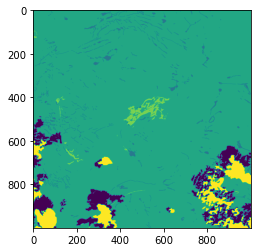

In [4]:
import matplotlib.pyplot as plt
plt.imshow(label_data[0])

In [5]:
import tensorflow as tf
label_data = tf.one_hot(indices = label_data, depth = 7, dtype=tf.int8)

TensorShape([78, 1000, 1000, 7])

In [41]:
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, GaussianNoise, Dropout, BatchNormalization, Activation, Conv2DTranspose



def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def deconv_block(tensor, residual, nfilters, size=3, padding='same', strides=(2, 2)):
    y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=strides, padding=padding)(tensor)
    y = concatenate([y, residual], axis=3)
    y = conv_block(y, nfilters)
    return y


def unet4(img_height, img_width, img_depth, nclasses=3, filters=64):
# down
    input_layer = Input(shape=(img_height, img_width, img_depth), name='image_input')
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = Dropout(0.5)(conv4_out)
    conv5 = conv_block(conv4_out, nfilters=filters*16)
    conv5 = Dropout(0.5)(conv5)
# up
    deconv6 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6 = Dropout(0.5)(deconv6)
    deconv7 = deconv_block(deconv6, residual=conv3, nfilters=filters*4)
    deconv7 = Dropout(0.5)(deconv7) 
    deconv8 = deconv_block(deconv7, residual=conv2, nfilters=filters*2)
    deconv9 = deconv_block(deconv8, residual=conv1, nfilters=filters)
# output
    output_layer = Conv2D(filters=nclasses, kernel_size=(1, 1))(deconv9)
    output_layer = BatchNormalization()(output_layer)
    output_layer = Activation('softmax')(output_layer)

    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    return model

In [42]:

model = unet4(512, 512, 10, nclasses=7, filters=64)

In [43]:
train_data = train_data[:,:512,:512]
label_data = label_data[:,:512,:512]

In [44]:
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam
model.compile(loss = "categorical_crossentropy", optimizer=Adam())

In [47]:
model.fit(train_data, label_data, batch_size=13, 
            steps_per_epoch=len(train_data) / 13, epochs=30)

Epoch 1/30
6/6 [==============================] - 6s 1s/step - loss: 0.9595
Epoch 2/30
6/6 [==============================] - 6s 1s/step - loss: 1.0074
Epoch 3/30
6/6 [==============================] - 6s 1s/step - loss: 0.9542
Epoch 4/30
6/6 [==============================] - 7s 1s/step - loss: 0.9657
Epoch 5/30
6/6 [==============================] - 7s 1s/step - loss: 0.9899
Epoch 6/30
6/6 [==============================] - 6s 1s/step - loss: 0.9317
Epoch 7/30
6/6 [==============================] - 6s 1s/step - loss: 0.9374
Epoch 8/30
6/6 [==============================] - 7s 1s/step - loss: 0.9522
Epoch 9/30
6/6 [==============================] - 6s 1s/step - loss: 0.9115
Epoch 10/30
6/6 [==============================] - 7s 1s/step - loss: 0.9150
Epoch 11/30
6/6 [==============================] - 6s 1s/step - loss: 0.9049
Epoch 12/30
6/6 [==============================] - 6s 1s/step - loss: 0.8674
Epoch 13/30
6/6 [==============================] - 6s 1s/step - loss: 0.8678
Epoch 14

In [48]:
pred = model.predict(train_data[:13])

In [49]:
pred_im = np.argmax(pred[0], axis = 2)

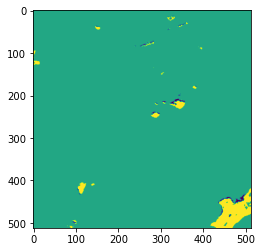

In [50]:
import matplotlib.pyplot as plt

plt.imshow(pred_im)

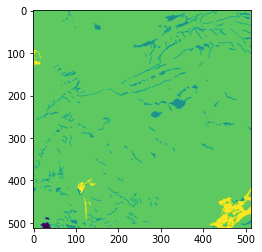

In [53]:
plt.imshow(np.argmax(label_data[0], axis = 2))

In [3]:
from unet import unet4

img_rows = 512
img_cols = 512
img_channels = 10
nb_classes = 7

checkpoint_filepath = "tmp/checkpoint"
model = unet4(img_rows, img_cols, img_channels, nclasses=nb_classes, filters=32)
model.load_weights(checkpoint_filepath)

In [4]:
import os
import tifffile as tif
import numpy as np
from unet import unet4
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam

# -- Throtling GPU usage by Tensorflow--

tf.autograph.set_verbosity(0)
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)


# -- Loading the datasets --

filenames = [file[:-8] for file in os.listdir("./data-landsat/") if "_data.tif" in file]

data = np.array([tif.imread("data-landsat/" + filenames[i]+"data.tif") for i in range(len(filenames))])
labels = np.array([tif.imread("data-landsat/" + filenames[i]+"labels.tif") for i in range(len(filenames))])
print(data.shape)
# -- Data Preprocessing --

#Splitting all images in four patches
data = np.concatenate((data[:,:512, :512,:], data[:,:512, 488:,:], data[:, 488:,:512,:],data[:, 488:, 488:,:]), axis = 0)
labels = np.concatenate((labels[:,:512, :512], labels[:,:512, 488:], labels[:, 488:,:512],labels[:, 488:, 488:]), axis = 0)
print(data.shape)

## One-Hot Encoding
labels = tf.one_hot(indices = labels, depth = 7, dtype=tf.int8)

## Splitting into training, validation and testing dataset
train_data, train_labels = data[:61], labels[:61]
val_data, val_labels = data[61:71], labels[61:71]
test_data, test_labels = data[71:], labels[71:]

(78, 1000, 1000, 10)
(312, 512, 512, 10)


In [5]:
test_pred = model.predict(test_data)

In [7]:
test_pred.shape

(241, 512, 512, 7)

In [8]:
test_data.shape

(241, 512, 512, 10)

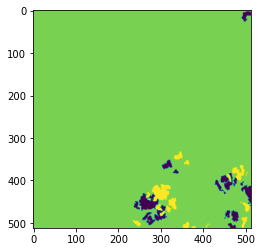

In [11]:
import matplotlib.pyplot as plt

plt.imshow(np.argmax(test_labels[0], axis = 2))

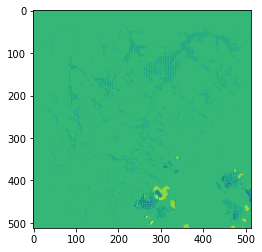

In [13]:
plt.imshow(np.argmax(test_pred[0], axis = 2))

In [14]:
from sklearn.metrics import jaccard_score

In [19]:
jaccard_score(np.argmax(test_labels[0], axis = 2).flatten(), np.argmax(test_pred[0], axis = 2).flatten(), labels = [0,1,2,3,4,5,6], average = "weighted")

0.9330453238556237

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
generator = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, label_mode="categorical")

TypeError: __init__() got an unexpected keyword argument 'label_mode'

In [1]:
import numpy as np
import tifffile as tif

filenames = [file[:-8] for file in os.listdir("./data-landsat/") if "_data.tif" in file]

data = np.array([tif.imread("data-landsat/" + filenames[i]+"data.tif") for i in range(len(filenames))])
labels = np.array([tif.imread("data-landsat/" + filenames[i]+"labels.tif") for i in range(len(filenames))])
print(data.shape)
# -- Data Preprocessing --

#Splitting all images in four patches
data = np.concatenate((data[:,:512, :512,:], data[:,:512, 488:,:], data[:, 488:,:512,:],data[:, 488:, 488:,:]), axis = 0)
labels = np.concatenate((labels[:,:512, :512], labels[:,:512, 488:], labels[:, 488:,:512],labels[:, 488:, 488:]), axis = 0)
print(data.shape)



## Splitting into training, validation and testing dataset
train_data, train_labels = data[:4*61], labels[:4*61]
val_data, val_labels = data[4*61:4*71], labels[4*61:4*71]
test_data, test_labels = data[4*71:], labels[4*71:]

del data
del labels

(78, 1000, 1000, 10)
(312, 512, 512, 10)


In [2]:
l, x, y = train_labels.shape
new_shape = (l, x, y, 1)

train_labels_r = np.reshape(train_labels, new_shape)

In [3]:
train_labels_r.shape

(244, 512, 512, 1)

In [6]:
import tensorflow as tf



image_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
mask_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)

seed = 1
image_datagen.fit(train_data, augment=True, seed=seed)
mask_datagen.fit(train_labels_r, augment=True, seed=seed)

image_generator = image_datagen.flow(
    train_data,
    seed=seed)



mask_generator = mask_datagen.flow(
    train_labels_r,
    seed=seed)

In [24]:
def image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        mask_squeezed = np.squeeze(mask)
        mask_one_hot = tf.one_hot(mask_squeezed, depth=7, dtype=tf.int8)

        yield img, mask_one_hot

In [25]:
gen = image_mask_generator(image_generator, mask_generator)

In [26]:
a = next(gen)

In [27]:
a[1]

<tf.Tensor: shape=(32, 512, 512, 7), dtype=int8, numpy=
array([[[[0, 0, 1, ..., 0, 0, 0],
         [0, 0, 1, ..., 0, 0, 0],
         [0, 0, 1, ..., 0, 0, 0],
         ...,
         [1, 0, 0, ..., 0, 0, 0],
         [1, 0, 0, ..., 0, 0, 0],
         [1, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 1, ..., 0, 0, 0],
         [0, 0, 1, ..., 0, 0, 0],
         [0, 0, 1, ..., 0, 0, 0],
         ...,
         [1, 0, 0, ..., 0, 0, 0],
         [1, 0, 0, ..., 0, 0, 0],
         [1, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 1, ..., 0, 0, 0],
         [0, 0, 1, ..., 0, 0, 0],
         [0, 0, 1, ..., 0, 0, 0],
         ...,
         [1, 0, 0, ..., 0, 0, 0],
         [1, 0, 0, ..., 0, 0, 0],
         [1, 0, 0, ..., 0, 0, 0]],

        ...,

        [[0, 0, 1, ..., 0, 0, 0],
         [0, 0, 1, ..., 0, 0, 0],
         [0, 0, 1, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 1, 0],
         [0, 0, 0, ..., 0, 1, 0],
         [0, 0, 0, ..., 0, 1, 0]],

        [[0, 0, 1, ..., 0, 0, 0],
         [0, 0, 

In [28]:
import matplotlib.pyplot as plt

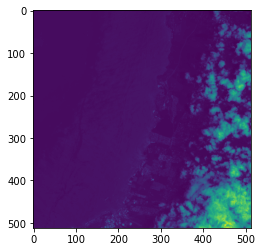

In [31]:
plt.imshow(a[0][0][:,:,1])

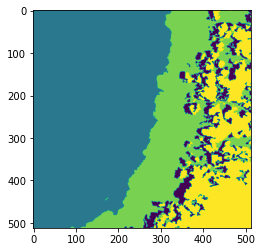

In [32]:
plt.imshow(np.argmax(a[1][0], axis = 2))

In [4]:
from unet import unet4

checkpoint_filepath = "tmp/checkpoint"
model = unet4(512, 512, 10, nclasses=7, filters=32)
model.load_weights(checkpoint_filepath)


pred = model.predict(test_data)

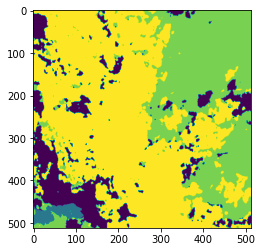

In [9]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(np.argmax(pred[1], axis=2))

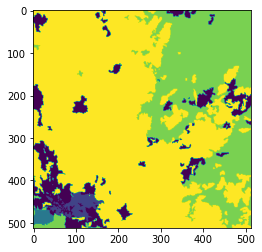

In [8]:
plt.imshow(test_labels[1])

ot).optimizer's state 'm' for (root).layer_with_weights-2.kernel


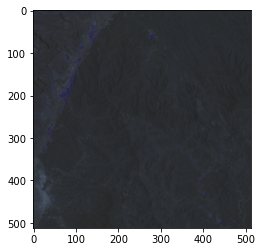

In [18]:
plt.imshow(test_data[0][:,:,2:]/np.amax(test_data))

In [26]:
from sklearn.metrics import jaccard_score


jaccard_score(test_labels[0].flatten(), np.argmax(pred[0], axis = 2).flatten(), labels = [0,1,2,3,4,5,6], average = "micro")

0.9988486246401952

In [23]:
test_labels[0]

array([[4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       ...,
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4]], dtype=uint8)

In [24]:
np.argmax(pred[0], axis = 2)

array([[4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       ...,
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4]])

In [2]:
from sklearn.utils import class_weight
import numpy as np
import tifffile as tif

filenames = [file[:-8] for file in os.listdir("./data-landsat/") if "_data.tif" in file]

data = np.array([tif.imread("data-landsat/" + filenames[i]+"data.tif") for i in range(len(filenames))])
labels = np.array([tif.imread("data-landsat/" + filenames[i]+"labels.tif") for i in range(len(filenames))])

class_weights = class_weight.compute_class_weight(dict, classes = [i for i in range(0, 7)], y=labels.flatten())

TypeError: unhashable type: 'numpy.ndarray'